In [1]:
import sys
sys.path.append('../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt
# import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D

powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, climateimpact)

powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
climateimpact.aircraft = myaircraft

ConstraintsInput = {'speed': np.array([0.4, 140, 170, 210, 0.5, 0.35, 104.]) ,
                    'speedtype': ['Mach','KCAS','KCAS','KCAS','Mach','Mach','KCAS']   ,
                    'beta': np.array([0.95,0.985,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.2, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.75,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'}}

ClimateImpactInput = {'H': 100, 'N':497*50, 'Y':30, 'EINOx_model':'Filippone'}

myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.ClimateImpactInput = ClimateImpactInput
myaircraft.Configuration = 'Traditional'

myaircraft.constraint.SetInput()
myaircraft.aerodynamics.SetInput()
myaircraft.powertrain.SetInput()
myaircraft.weight.SetInput()
myaircraft.climateimpact.SetInput()

In [2]:
WTOoS = np.array([])
PW = np.array([])
fuel_mass = np.array([])   
structure_mass = np.array([])
powertrain_mass = np.array([])
takeoff_weight = np.array([])
wing_surface = np.array([])
CO2 = np.array([])
H2O = np.array([])
SO4 = np.array([])
soot = np.array([])
NOx = np.array([])
ATR = np.array([])


years = np.linspace(0, myaircraft.climateimpact.H+1, 30)
mach = np.linspace(0.3, 0.55, 20)

years_grid, mach_grid = np.meshgrid(years, mach)

DeltaT_values = np.zeros_like(years_grid)

In [3]:
for i in range(len(mach)):
    MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': mach[i], 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}
    myaircraft.MissionStages = MissionStages
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()

    myaircraft.constraint.FindDesignPoint()
    WTOoS = np.append(WTOoS,myaircraft.DesignWTOoS)
    PW = np.append(WTOoS,myaircraft.DesignPW)

    myaircraft.weight.WeightEstimation()
    fuel_mass = np.append(fuel_mass, myaircraft.weight.Wf)  # [kg]  riserva non compresa
    structure_mass = np.append(structure_mass, myaircraft.weight.WStructure)  # [kg]
    powertrain_mass = np.append(powertrain_mass, myaircraft.weight.WPT)  # [kg]
    takeoff_weight = np.append(takeoff_weight, myaircraft.weight.WTO)  # [kg]

    myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 
    wing_surface = np.append(wing_surface, myaircraft.WingSurface)

    myaircraft.climateimpact.calculate_mission_emissions()
    CO2 = np.append(CO2, myaircraft.climateimpact.mission_emissions['co2'])  # [kg]
    H20 = np.append(H2O, myaircraft.climateimpact.mission_emissions['h2o'])  # [kg]
    SO4 = np.append(SO4, myaircraft.climateimpact.mission_emissions['so4'])  # [kg]
    soot = np.append(soot, myaircraft.climateimpact.mission_emissions['soot'])  # [kg]
    NOx = np.append(NOx, myaircraft.climateimpact.mission_emissions['nox'])  # [kg]

    atr = myaircraft.climateimpact.ATR()
    ATR = np.append(ATR, atr)

    for j in range(len(years)):
        DeltaT_values[i,j] = myaircraft.climateimpact.DeltaT(years[j])


In [5]:
np.savez('output_param_speed.npz',
         WTOoS=WTOoS,
         PW=PW,
         fuel_mass=fuel_mass,
         structure_mass=structure_mass,
         powertrain_mass=powertrain_mass,
         takeoff_weight=takeoff_weight,
         wing_surface=wing_surface,
         CO2=CO2,
         H2O=H2O,
         SO4=SO4,
         soot=soot,
         NOx=NOx,
         ATR=ATR,
         DeltaT_values=DeltaT_values)

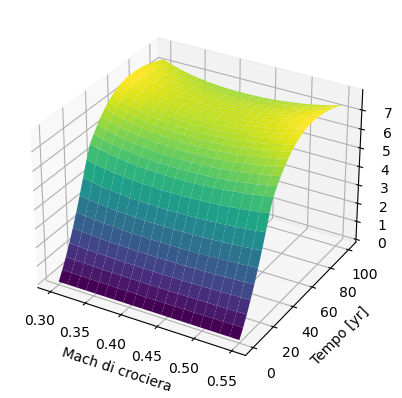

In [6]:

# data = np.load('output_param_speed.npz')
# DeltaT_values = data['DeltaT_values']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mach_grid, years_grid, DeltaT_values, cmap='viridis')

ax.set_xlabel('Mach di crociera')
ax.set_ylabel('Tempo [yr]')
ax.set_zlabel(r'$\Delta$T [K]')
plt.show()

In [7]:
ATR_min = np.min(ATR)
indice_minimo = np.argmin(ATR)
print(mach[indice_minimo])

0.41842105263157897


In [8]:
print(DeltaT_values)

[[0.00000000e+00 4.69178604e-07 9.94973134e-07 1.57571375e-06
  2.20958976e-06 2.89322242e-06 3.62213470e-06 4.39126539e-06
  5.19534422e-06 5.85503226e-06 6.22202045e-06 6.55343374e-06
  6.84597872e-06 7.09833330e-06 7.31045385e-06 7.48448743e-06
  7.62173706e-06 7.72620511e-06 7.80034877e-06 7.84714239e-06
  7.86891803e-06 7.86938060e-06 7.85111398e-06 7.81590409e-06
  7.76591207e-06 7.70430330e-06 7.63166635e-06 7.54990345e-06
  7.46058343e-06 7.36452023e-06]
 [0.00000000e+00 4.61115819e-07 9.76706829e-07 1.54535237e-06
  2.16544086e-06 2.83378955e-06 3.54611344e-06 4.29753480e-06
  5.08295511e-06 5.72602906e-06 6.08185095e-06 6.40360861e-06
  6.68791389e-06 6.93334491e-06 7.13976422e-06 7.30919579e-06
  7.44290742e-06 7.54462021e-06 7.61685197e-06 7.66243448e-06
  7.68363042e-06 7.68404453e-06 7.66619096e-06 7.63180747e-06
  7.58299961e-06 7.52285489e-06 7.45166530e-06 7.37212639e-06
  7.28492955e-06 7.19114761e-06]
 [0.00000000e+00 4.54318299e-07 9.61425297e-07 1.52008809e-06
  2.